# Students and Sections 3
[1. Introduction](#introduction)

[2. Preliminary data processing](#prelim)

[3. Complete case analysis](#comp)

[4. Imputation of missing exam results](#imp)

[5. Conclusions](#conc)

## 1. Introduction<a id='introduction'></a>
In this notebook we'll use a dataset containing data for each first-attempt at each exam for each student (see the notebook 'merge_years' for the details on how this dataset was created from the ones for the different courses). We'll just take the Bayesian approach here, using models similar to those from the previous notebook, and we are primarily interested in the coefficient $\beta_S$ representing the influence of section numbering on exam results.

We'll train just two models. The first uses only the complete cases (i.e. those where all exam results are available), and the second tries to impute missing exam results.

## 2. Preliminary data processing<a id='prelim'></a>

In [1]:
num_iters = 10000
library(rstan)
library(loo)

Loading required package: StanHeaders


rstan version 2.26.13 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

This is loo version 2.5.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

- Windows 10 users: loo may be very slow if 'mc.cores' is set in your .Rprofile file (see https://github.com/stan-dev/loo/issues/94).


Attaching package: 'loo'


The following object is masked from 'package:r

In [2]:
# A conveinece function for printing the proportion of the probability mass for the bS parameter below a specified value
# and a specified model.
prop_below <- function(model, prop) {
    samples <- extract(model, 'bS') 
    counts <- ifelse(samples$bS < prop, 1, 0)
    p <- sum(counts)/length(counts)
    paste("Proportion less than", prop, ":", p, sep = " ")
}

In [3]:
data <- read.csv("students_combined.csv", header=TRUE, stringsAsFactors=FALSE)

df_base <- data.frame(data)
str(df_base)

'data.frame':	1674 obs. of  8 variables:
 $ Cohort            : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Section.Y1        : num  1 2 1 1 1 1 1 1 1 2 ...
 $ Midterm.Y1        : chr  "" "" "" "" ...
 $ Final.Y1          : chr  "" "" "" "" ...
 $ Teacher.Midterm.Y1: num  NA NA NA NA NA NA NA NA NA NA ...
 $ Teacher.Final.Y1  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Section.Y2        : num  1 2 1 1 1 1 1 1 1 2 ...
 $ Exam.Y2           : chr  "97.78" "95.56" "95.56" "94.44" ...


In [4]:
df_base$Score_1 <- as.numeric(df_base$Midterm.Y1)
df_base$Score_2 <- as.numeric(df_base$Final.Y1)
df_base$Score_3 <- as.numeric(df_base$Exam.Y2)
str(df_base)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


'data.frame':	1674 obs. of  11 variables:
 $ Cohort            : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Section.Y1        : num  1 2 1 1 1 1 1 1 1 2 ...
 $ Midterm.Y1        : chr  "" "" "" "" ...
 $ Final.Y1          : chr  "" "" "" "" ...
 $ Teacher.Midterm.Y1: num  NA NA NA NA NA NA NA NA NA NA ...
 $ Teacher.Final.Y1  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Section.Y2        : num  1 2 1 1 1 1 1 1 1 2 ...
 $ Exam.Y2           : chr  "97.78" "95.56" "95.56" "94.44" ...
 $ Score_1           : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Score_2           : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Score_3           : num  97.8 95.6 95.6 94.4 93.3 ...


## 3. Complete case analysis<a id='comp'></a>
Here we simply drop the cases where there is no data for an exam. We will later use a more sophisticated strategy for dealing with these missing values.

In [5]:
df <- df_base[complete.cases(df_base$Score_1, df_base$Score_2, df_base$Score_3), ]
str(df)

'data.frame':	1289 obs. of  11 variables:
 $ Cohort            : num  2 2 2 2 2 2 2 2 2 2 ...
 $ Section.Y1        : num  1 1 1 1 1 1 2 1 1 1 ...
 $ Midterm.Y1        : chr  "76.5" "78.5" "69.5" "61.5" ...
 $ Final.Y1          : chr  "67" "61" "64" "70" ...
 $ Teacher.Midterm.Y1: num  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher.Final.Y1  : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Section.Y2        : num  1 1 1 1 1 1 2 1 1 1 ...
 $ Exam.Y2           : chr  "92" "92" "91" "91" ...
 $ Score_1           : num  76.5 78.5 69.5 61.5 71.5 79.5 49 72 67.5 63.5 ...
 $ Score_2           : num  67 61 64 70 65 68 50 85 55 65 ...
 $ Score_3           : num  92 92 91 91 91 90 90 90 90 89 ...


In [6]:
drops <- c("Midterm.Y1","Final.Y1","Exam.Y2","Teacher.Midterm.Y1","Teacher.Final.Y1")
df <- df[ , !(names(df) %in% drops)]
str(df)

summary(df)

'data.frame':	1289 obs. of  6 variables:
 $ Cohort    : num  2 2 2 2 2 2 2 2 2 2 ...
 $ Section.Y1: num  1 1 1 1 1 1 2 1 1 1 ...
 $ Section.Y2: num  1 1 1 1 1 1 2 1 1 1 ...
 $ Score_1   : num  76.5 78.5 69.5 61.5 71.5 79.5 49 72 67.5 63.5 ...
 $ Score_2   : num  67 61 64 70 65 68 50 85 55 65 ...
 $ Score_3   : num  92 92 91 91 91 90 90 90 90 89 ...


     Cohort        Section.Y1      Section.Y2      Score_1         Score_2     
 Min.   :2.000   Min.   :1.000   Min.   :1.00   Min.   : 5.00   Min.   : 2.00  
 1st Qu.:3.000   1st Qu.:1.000   1st Qu.:1.00   1st Qu.:32.50   1st Qu.:33.30  
 Median :5.000   Median :2.000   Median :2.00   Median :46.00   Median :47.50  
 Mean   :5.265   Mean   :1.963   Mean   :1.96   Mean   :47.45   Mean   :48.97  
 3rd Qu.:8.000   3rd Qu.:3.000   3rd Qu.:3.00   3rd Qu.:61.50   3rd Qu.:65.00  
 Max.   :9.000   Max.   :3.000   Max.   :3.00   Max.   :97.00   Max.   :99.00  
    Score_3     
 Min.   : 0.00  
 1st Qu.:32.00  
 Median :51.00  
 Mean   :49.38  
 3rd Qu.:67.00  
 Max.   :97.00  

As usual we'll standardize exam results to allow comparison between years.

In [7]:
for (y in 2 : 9){
  index <- df$Cohort == y
    
  m <- mean(df$Score_1[index])
  s <- sd(df$Score_1[index])
  df$Score_1_std[index] <- ( df$Score_1[index] - m )/s
    
  m <- mean(df$Score_2[index])
  s <- sd(df$Score_2[index])
  df$Score_2_std[index] <- ( df$Score_2[index] - m )/s
    
  m <- mean(df$Score_3[index])
  s <- sd(df$Score_3[index])
  df$Score_3_std[index] <- ( df$Score_3[index] - m )/s  
    }

summary(df)

     Cohort        Section.Y1      Section.Y2      Score_1         Score_2     
 Min.   :2.000   Min.   :1.000   Min.   :1.00   Min.   : 5.00   Min.   : 2.00  
 1st Qu.:3.000   1st Qu.:1.000   1st Qu.:1.00   1st Qu.:32.50   1st Qu.:33.30  
 Median :5.000   Median :2.000   Median :2.00   Median :46.00   Median :47.50  
 Mean   :5.265   Mean   :1.963   Mean   :1.96   Mean   :47.45   Mean   :48.97  
 3rd Qu.:8.000   3rd Qu.:3.000   3rd Qu.:3.00   3rd Qu.:61.50   3rd Qu.:65.00  
 Max.   :9.000   Max.   :3.000   Max.   :3.00   Max.   :97.00   Max.   :99.00  
    Score_3       Score_1_std       Score_2_std        Score_3_std      
 Min.   : 0.00   Min.   :-2.5095   Min.   :-2.36338   Min.   :-3.07995  
 1st Qu.:32.00   1st Qu.:-0.7442   1st Qu.:-0.75265   1st Qu.:-0.68567  
 Median :51.00   Median :-0.1128   Median :-0.06112   Median : 0.01744  
 Mean   :49.38   Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.:67.00   3rd Qu.: 0.6857   3rd Qu.: 0.80705   3rd Qu.: 0.72903  
 M

### The first model
$i\in\{1,\ldots,N\}$ ($N$ is number of students) and $k\in\{1,2,3\}$ (exams)

#### Model

$E \sim MultiNormal(\mu, \Sigma)$ ...   ($E$ is a multivariate normal distribution for two variables. As is typical, the covariance matrix $\Sigma$ will be modeled using a vector of standard deviations $\tau$ and a correlation matrix $\Omega$ as $\Sigma = \tau_{diag}\ast\Omega\ast \tau_{diag}$).

$\mu_k = \alpha_k + \beta_A\sum_{i=1}^{N_A-1} \delta_i^A + \beta_S \sum_{j=i}^{N_S-1} \delta_j^B$

#### Priors

$\tau \sim LogNorm(0,0.25)$

$\Omega\sim LKJcorr(2)$

$(\delta^A_1, \delta^A_2), (\delta^S_1, \delta^S_2) \sim Dirichlet(2,2)$

$a_k, \beta_A, \beta_S \sim Norm(0,1)$

In [8]:
df_full <- df

df_full$Stream_level.Y1 <- ifelse(df_full$Section.Y1 == 1 & df_full$Cohort < 6, 3., ifelse(df_full$Cohort < 6, 1., 2. ))
df_full$Stream_level.Y2 <- ifelse(df_full$Section.Y2 == 1 & df_full$Cohort < 6, 3., ifelse(df_full$Cohort < 6, 1., 2. ))
str(df_full)

df_trim <- df_full
drops <- c("Score_1","Score_2","Score_3")
df_trim <- df_trim[ , !(names(df) %in% drops)]

str(df_trim)

summary(df_trim)

'data.frame':	1289 obs. of  11 variables:
 $ Cohort         : num  2 2 2 2 2 2 2 2 2 2 ...
 $ Section.Y1     : num  1 1 1 1 1 1 2 1 1 1 ...
 $ Section.Y2     : num  1 1 1 1 1 1 2 1 1 1 ...
 $ Score_1        : num  76.5 78.5 69.5 61.5 71.5 79.5 49 72 67.5 63.5 ...
 $ Score_2        : num  67 61 64 70 65 68 50 85 55 65 ...
 $ Score_3        : num  92 92 91 91 91 90 90 90 90 89 ...
 $ Score_1_std    : num  2.01 2.12 1.61 1.15 1.72 ...
 $ Score_2_std    : num  1.68 1.3 1.49 1.86 1.55 ...
 $ Score_3_std    : num  1.73 1.73 1.68 1.68 1.68 ...
 $ Stream_level.Y1: num  3 3 3 3 3 3 1 3 3 3 ...
 $ Stream_level.Y2: num  3 3 3 3 3 3 1 3 3 3 ...
'data.frame':	1289 obs. of  8 variables:
 $ Cohort         : num  2 2 2 2 2 2 2 2 2 2 ...
 $ Section.Y1     : num  1 1 1 1 1 1 2 1 1 1 ...
 $ Section.Y2     : num  1 1 1 1 1 1 2 1 1 1 ...
 $ Score_1_std    : num  2.01 2.12 1.61 1.15 1.72 ...
 $ Score_2_std    : num  1.68 1.3 1.49 1.86 1.55 ...
 $ Score_3_std    : num  1.73 1.73 1.68 1.68 1.68 ...
 $ Stream_

     Cohort        Section.Y1      Section.Y2    Score_1_std     
 Min.   :2.000   Min.   :1.000   Min.   :1.00   Min.   :-2.5095  
 1st Qu.:3.000   1st Qu.:1.000   1st Qu.:1.00   1st Qu.:-0.7442  
 Median :5.000   Median :2.000   Median :2.00   Median :-0.1128  
 Mean   :5.265   Mean   :1.963   Mean   :1.96   Mean   : 0.0000  
 3rd Qu.:8.000   3rd Qu.:3.000   3rd Qu.:3.00   3rd Qu.: 0.6857  
 Max.   :9.000   Max.   :3.000   Max.   :3.00   Max.   : 2.8375  
  Score_2_std        Score_3_std       Stream_level.Y1 Stream_level.Y2
 Min.   :-2.36338   Min.   :-3.07995   Min.   :1.000   Min.   :1.000  
 1st Qu.:-0.75265   1st Qu.:-0.68567   1st Qu.:1.000   1st Qu.:1.000  
 Median :-0.06112   Median : 0.01744   Median :2.000   Median :2.000  
 Mean   : 0.00000   Mean   : 0.00000   Mean   :1.815   Mean   :1.823  
 3rd Qu.: 0.80705   3rd Qu.: 0.72903   3rd Qu.:2.000   3rd Qu.:2.000  
 Max.   : 2.99903   Max.   : 2.59928   Max.   :3.000   Max.   :3.000  

In [9]:
dat_1 <- list(
  N = 1289,
  K = 3,
  A_1 = df_trim$Stream_level.Y1,
  A_2 = df_trim$Stream_level.Y2,  
  S_1 = df_trim$Section.Y1,
  S_2 = df_trim$Section.Y2,
  E = matrix(c(df_trim$Score_1_std, df_trim$Score_2_std, df_trim$Score_3_std), ncol = 3),
  alpha = rep( 2 , 2 ))

str(dat_1)

List of 8
 $ N    : num 1289
 $ K    : num 3
 $ A_1  : num [1:1289] 3 3 3 3 3 3 1 3 3 3 ...
 $ A_2  : num [1:1289] 3 3 3 3 3 3 1 3 3 3 ...
 $ S_1  : num [1:1289] 1 1 1 1 1 1 2 1 1 1 ...
 $ S_2  : num [1:1289] 1 1 1 1 1 1 2 1 1 1 ...
 $ E    : num [1:1289, 1:3] 2.01 2.12 1.61 1.15 1.72 ...
 $ alpha: num [1:2] 2 2


In [10]:
code_1 <- 'data{
    int<lower=1> K;
    int<lower=0> N;
    int S_1[N];
    int S_2[N];
    int A_1[N];
    int A_2[N];
    array[N] vector[K] E;
    vector[2] alpha;
}
parameters{
    corr_matrix[K] Omega;     
    vector<lower=0>[K] tau;
    real bA;
    real bS;
    real a_1;
    real a_2;
    real a_3;
    simplex[2] deltaA;
    simplex[2] deltaS;
}

transformed parameters{
    vector[3] deltaA_j;
    vector[3] deltaS_j;
    deltaS_j = append_row(0, deltaS);
    deltaA_j = append_row(0, deltaA);
}

model{
    tau ~ lognormal( 0, 0.25 );
    Omega ~ lkj_corr(2);
    array[N] vector[K] phi;
    deltaS ~ dirichlet( alpha );
    deltaA ~ dirichlet( alpha );
    a_1 ~ normal( 0 , 1 );
    a_2 ~ normal( 0 , 1 );
    a_3 ~ normal( 0 , 1 );
    bA ~ normal( 0 , 1 );
    bS ~ normal( 0 , 1 );

    for ( i in 1:N ) {
        phi[i][1] = a_1 + bA*sum(deltaA_j[1:A_1[i]]) + bS*sum(deltaS_j[1:S_1[i]]);
        phi[i][2] = a_2 + bA*sum(deltaA_j[1:A_1[i]]) + bS*sum(deltaS_j[1:S_1[i]]);
        phi[i][3] = a_3 + bA*sum(deltaA_j[1:A_2[i]]) + bS*sum(deltaS_j[1:S_2[i]]);
    }
    E ~ multi_normal(phi, quad_form_diag(Omega, tau));
}

generated quantities{
    vector[N] log_lik; 
    array[N] vector[K] phi;
    for ( i in 1:N ) {
        phi[i][1] = a_1 + bA*sum(deltaA_j[1:A_1[i]]) + bS*sum(deltaS_j[1:S_1[i]]);
        phi[i][2] = a_2 + bA*sum(deltaA_j[1:A_1[i]]) + bS*sum(deltaS_j[1:S_1[i]]);
        phi[i][3] = a_3 + bA*sum(deltaA_j[1:A_2[i]]) + bS*sum(deltaS_j[1:S_2[i]]);
        log_lik[i] = multi_normal_lpdf(E[i] | phi[i] , quad_form_diag(Omega, tau) );
    }
}
'



In [11]:
model_1 <- stan( model_code = code_1 , data = dat_1 , chains=4, cores = 4, iter = num_iters )

In [12]:
pars = c('a_1', 'a_2', 'a_3', 'bA', 'bS', 'deltaS', 'deltaA')
results_2 <- summary(model_1, pars = pars, probs = c(0.025, 0.975))$summary
results_2

,mean,se_mean,sd,2.5%,97.5%,n_eff,Rhat
a_1,-0.2101693,0.0009601557,0.07061449,-0.34419680,-0.06945545,5408.841,1.001815
a_2,-0.2103946,0.0009614024,0.07057149,-0.34468166,-0.07004957,5388.256,1.001727
a_3,-0.2136903,0.0009658700,0.07088213,-0.34732484,-0.07111323,5385.625,1.001810
bA,0.7888202,0.0010524132,0.08776745,0.61575058,0.95897974,6954.955,1.000922
bS,-0.1039330,0.0008340643,0.07024821,-0.24168425,0.03148059,7093.677,1.001137
deltaS[1],0.5878666,0.0017065250,0.20313802,0.15826743,0.92226673,14169.585,1.000140
deltaS[2],0.4121334,0.0017065250,0.20313802,0.07773327,0.84173257,14169.585,1.000140
deltaA[1],0.3374546,0.0005207963,0.05993725,0.22010733,0.45436907,13245.178,1.000569
deltaA[2],0.6625454,0.0005207963,0.05993725,0.54563093,0.77989267,13245.178,1.000569


Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.
ℹ The deprecated feature was likely used in the rstan package.
  Please report the issue at <https://github.com/stan-dev/rstan/issues/>."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


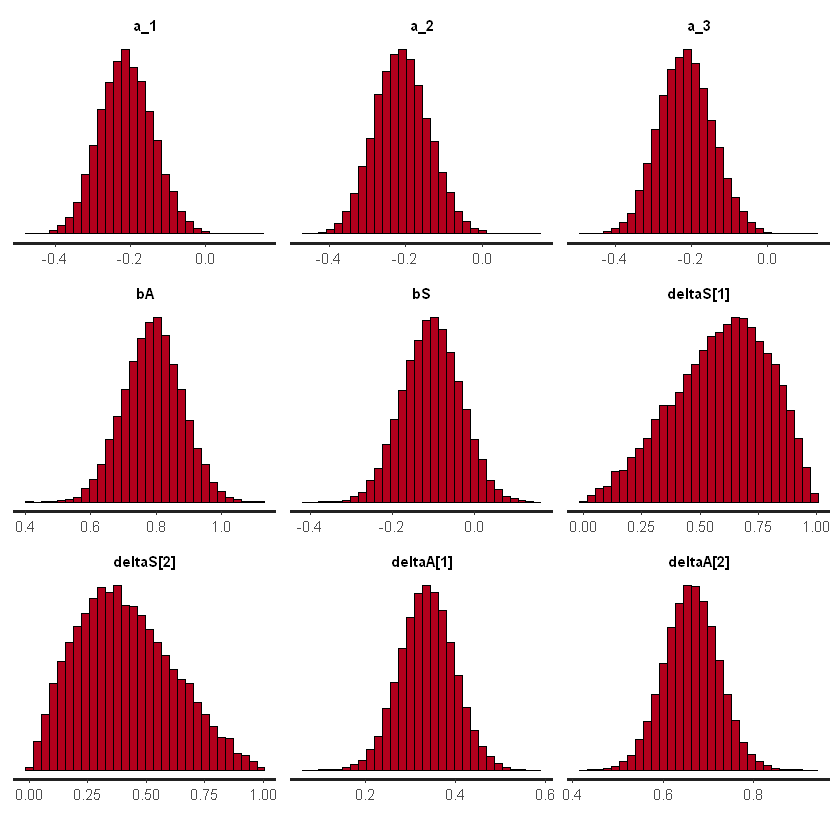

In [13]:
stan_hist(model_1, pars = pars)

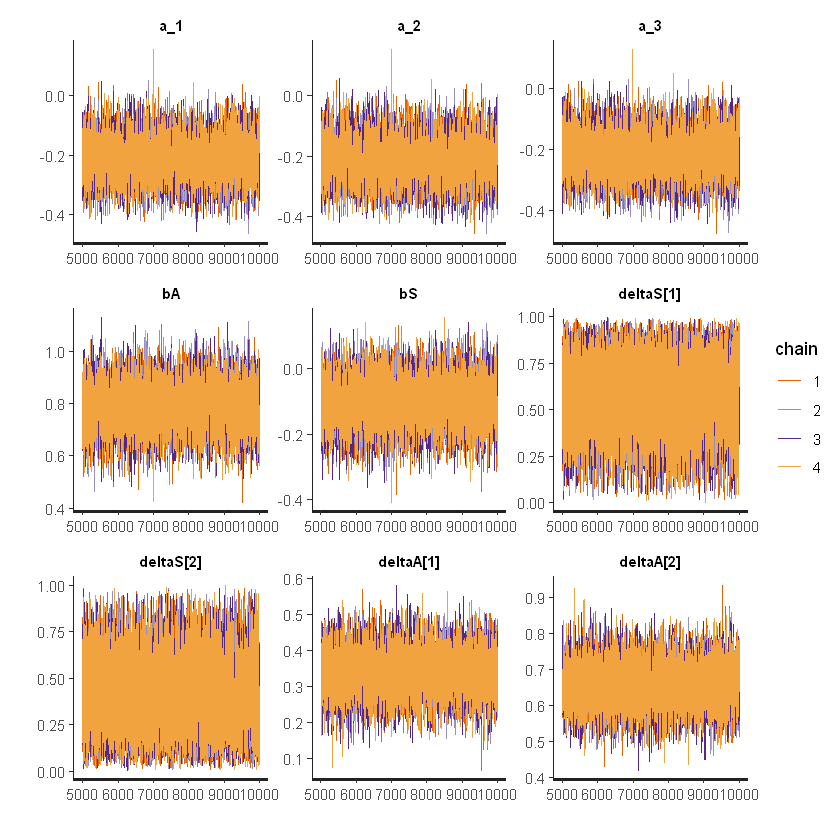

In [14]:
stan_trace(model_1, pars = pars)

In [15]:
prop_below(model_1,-0.1)

prop_below(model_1, -0.05)

prop_below(model_1, -0.01)

prop_below(model_1, 0)

[1] "Proportion less than -0.1 : 0.52095"

[1] "Proportion less than -0.05 : 0.77735"

[1] "Proportion less than -0.01 : 0.90905"

[1] "Proportion less than 0 : 0.92925"

In [16]:
loo_1 <- loo(model_1)
loo_1


Computed from 20000 by 1289 log-likelihood matrix

         Estimate   SE
elpd_loo  -4169.0 43.5
p_loo        12.3  0.5
looic      8338.1 87.0
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

This model is reasonably confident of a small effect of section numbering on exam results, with over 90% of the probability mass of the estimate of $\beta_S$ being below $-0.01$. There is quite a lot of uncertainty about the $\delta^S$ values, though on balance the model thinks the transition from section 1 to section 2 is a little more significant than the transition from section 2 to section 3. 

## 4. Imputation of missing exam results<a id='imp'></a>
Now we'll fit a model where missing exam results are imputed. This imputation treats missing exam results as a parameter produces the model's best estimate on the basis of the known values of section, academic selection level and whatever other exam results are known (as exam results are modeled as correlated).

In [17]:
df_m <- df_base

drops <- c("Midterm.Y1","Final.Y1","Exam.Y2","Teacher.Midterm.Y1","Teacher.Final.Y1")
df_m <- df_m[ , !(names(df_m) %in% drops)]
str(df_m)

summary(df_m)

'data.frame':	1674 obs. of  6 variables:
 $ Cohort    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Section.Y1: num  1 2 1 1 1 1 1 1 1 2 ...
 $ Section.Y2: num  1 2 1 1 1 1 1 1 1 2 ...
 $ Score_1   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Score_2   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Score_3   : num  97.8 95.6 95.6 94.4 93.3 ...


     Cohort        Section.Y1      Section.Y2       Score_1     
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   : 0.00  
 1st Qu.:2.000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:30.50  
 Median :4.000   Median :2.000   Median :2.000   Median :44.29  
 Mean   :4.782   Mean   :1.982   Mean   :1.977   Mean   :45.84  
 3rd Qu.:7.000   3rd Qu.:3.000   3rd Qu.:3.000   3rd Qu.:59.62  
 Max.   :9.000   Max.   :3.000   Max.   :3.000   Max.   :97.00  
                                                 NA's   :282    
    Score_2         Score_3     
 Min.   : 0.00   Min.   : 0.00  
 1st Qu.:31.70   1st Qu.:31.70  
 Median :46.50   Median :49.29  
 Mean   :47.86   Mean   :48.82  
 3rd Qu.:64.00   3rd Qu.:66.00  
 Max.   :99.00   Max.   :97.78  
 NA's   :317     NA's   :103    

Again we standardize scores, but here we do this on the basis of known results only.

In [18]:
for (y in 1 : 9){
  index <- df_m$Cohort == y
    
  m <- mean(df_m$Score_1[index], na.rm = TRUE)
  s <- sd(df_m$Score_1[index], na.rm = TRUE)
  df_m$Score_1_std[index] <- ( df_m$Score_1[index] - m )/s
    
  m <- mean(df_m$Score_2[index], na.rm = TRUE)
  s <- sd(df_m$Score_2[index], na.rm = TRUE)
  df_m$Score_2_std[index] <- ( df_m$Score_2[index] - m )/s
    
  m <- mean(df_m$Score_3[index], na.rm = TRUE)
  s <- sd(df_m$Score_3[index], na.rm = TRUE)
  df_m$Score_3_std[index] <- ( df_m$Score_3[index] - m )/s  
    }

summary(df_m)

     Cohort        Section.Y1      Section.Y2       Score_1     
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   : 0.00  
 1st Qu.:2.000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:30.50  
 Median :4.000   Median :2.000   Median :2.000   Median :44.29  
 Mean   :4.782   Mean   :1.982   Mean   :1.977   Mean   :45.84  
 3rd Qu.:7.000   3rd Qu.:3.000   3rd Qu.:3.000   3rd Qu.:59.62  
 Max.   :9.000   Max.   :3.000   Max.   :3.000   Max.   :97.00  
                                                 NA's   :282    
    Score_2         Score_3       Score_1_std       Score_2_std     
 Min.   : 0.00   Min.   : 0.00   Min.   :-2.5937   Min.   :-2.8137  
 1st Qu.:31.70   1st Qu.:31.70   1st Qu.:-0.7500   1st Qu.:-0.7694  
 Median :46.50   Median :49.29   Median :-0.1149   Median :-0.0729  
 Mean   :47.86   Mean   :48.82   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:64.00   3rd Qu.:66.00   3rd Qu.: 0.6951   3rd Qu.: 0.8082  
 Max.   :99.00   Max.   :97.78   Max.   : 2.8511   Max.   : 3.0172

In [19]:
df_m$Stream_level.Y1 <- ifelse(df_m$Section.Y1 == 1 & df_m$Cohort < 6, 3., ifelse(df_m$Cohort < 6, 1., 2. ))
df_m$Stream_level.Y2 <- ifelse(df_m$Section.Y2 == 1 & df_m$Cohort < 6, 3., ifelse(df_m$Cohort < 6, 1., 2. ))

drops <- c("Score_1","Score_2","Score_3")
df_m <- df_m[ , !(names(df_m) %in% drops)]

str(df_m)

summary(df_m)

'data.frame':	1674 obs. of  8 variables:
 $ Cohort         : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Section.Y1     : num  1 2 1 1 1 1 1 1 1 2 ...
 $ Section.Y2     : num  1 2 1 1 1 1 1 1 1 2 ...
 $ Score_1_std    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Score_2_std    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Score_3_std    : num  2.07 1.96 1.96 1.91 1.86 ...
 $ Stream_level.Y1: num  3 1 3 3 3 3 3 3 3 1 ...
 $ Stream_level.Y2: num  3 1 3 3 3 3 3 3 3 1 ...


     Cohort        Section.Y1      Section.Y2     Score_1_std     
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :-2.5937  
 1st Qu.:2.000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:-0.7500  
 Median :4.000   Median :2.000   Median :2.000   Median :-0.1149  
 Mean   :4.782   Mean   :1.982   Mean   :1.977   Mean   : 0.0000  
 3rd Qu.:7.000   3rd Qu.:3.000   3rd Qu.:3.000   3rd Qu.: 0.6951  
 Max.   :9.000   Max.   :3.000   Max.   :3.000   Max.   : 2.8511  
                                                 NA's   :282      
  Score_2_std       Score_3_std       Stream_level.Y1 Stream_level.Y2
 Min.   :-2.8137   Min.   :-3.06554   Min.   :1.000   Min.   :1.000  
 1st Qu.:-0.7694   1st Qu.:-0.71875   1st Qu.:1.000   1st Qu.:1.000  
 Median :-0.0729   Median :-0.01092   Median :2.000   Median :2.000  
 Mean   : 0.0000   Mean   : 0.00000   Mean   :1.787   Mean   :1.793  
 3rd Qu.: 0.8082   3rd Qu.: 0.75391   3rd Qu.:2.000   3rd Qu.:2.000  
 Max.   : 3.0172   Max.   : 2.61134   Max.  

### The second model

In [20]:
exam_matrix = matrix(c(df_m$Score_1_std, df_m$Score_2_std, df_m$Score_3_std), ncol = 3)
exam_matrix_zero = exam_matrix
exam_matrix_zero[is.na(exam_matrix)] <- 0
dat_2 <- list(
  N = 1674,
  K = 3,
  A_1 = df_m$Stream_level.Y1,
  A_2 = df_m$Stream_level.Y2,  
  S_1 = df_m$Section.Y1,
  S_2 = df_m$Section.Y2,
  E = exam_matrix_zero,
  E_missidx = which(is.na(exam_matrix)),
  N_missing = length(which(is.na(exam_matrix))),
  alpha = rep( 2 , 2 ))

str(dat_2)

List of 10
 $ N        : num 1674
 $ K        : num 3
 $ A_1      : num [1:1674] 3 1 3 3 3 3 3 3 3 1 ...
 $ A_2      : num [1:1674] 3 1 3 3 3 3 3 3 3 1 ...
 $ S_1      : num [1:1674] 1 2 1 1 1 1 1 1 1 2 ...
 $ S_2      : num [1:1674] 1 2 1 1 1 1 1 1 1 2 ...
 $ E        : num [1:1674, 1:3] 0 0 0 0 0 0 0 0 0 0 ...
 $ E_missidx: int [1:702] 1 2 3 4 5 6 7 8 9 10 ...
 $ N_missing: int 702
 $ alpha    : num [1:2] 2 2


In [21]:
code_2 <- '
data{
    int<lower=1> K;
    int<lower=0> N;
    int<lower=0> N_missing;
    int S_1[N];
    int S_2[N];
    int A_1[N];
    int A_2[N];
    int E_missidx[N_missing];
    matrix[N,K] E;
    vector[2] alpha;
}
parameters{
    corr_matrix[K] Omega;     
    vector<lower=0>[K] tau;
    real bA;
    real bS;
    real a_1;
    real a_2;
    real a_3;
    simplex[2] deltaA;
    simplex[2] deltaS;
    vector[N_missing] E_impute;
}

transformed parameters{
    vector[3] deltaA_j;
    vector[3] deltaS_j;
    deltaS_j = append_row(0, deltaS);
    deltaA_j = append_row(0, deltaA);
}

model{
    array[N] vector[K] E_merge;
    vector[3*N] E_vec;
    vector[K] temp_vec;
    E_vec = to_vector(E);
    tau ~ lognormal( 0, 0.25 );
    Omega ~ lkj_corr(2);
    array[N] vector[K] phi;
    deltaS ~ dirichlet( alpha );
    deltaA ~ dirichlet( alpha );
    a_1 ~ normal( 0 , 1 );
    a_2 ~ normal( 0 , 1 );
    a_3 ~ normal( 0 , 1 );
    bA ~ normal( 0 , 1 );
    bS ~ normal( 0 , 1 );
    for ( i in 1:N_missing )
        E_vec[ E_missidx[i] ] = E_impute[i];
    for ( i in 1:N ) {
        for (j in 1:K) {
            temp_vec[j] = E_vec[(j-1)*N + i];
        }
        E_merge[i] = temp_vec; 
        phi[i][1] = a_1 + bA*sum(deltaA_j[1:A_1[i]]) + bS*sum(deltaS_j[1:S_1[i]]);
        phi[i][2] = a_2 + bA*sum(deltaA_j[1:A_1[i]]) + bS*sum(deltaS_j[1:S_1[i]]);
        phi[i][3] = a_3 + bA*sum(deltaA_j[1:A_2[i]]) + bS*sum(deltaS_j[1:S_2[i]]);
    }
    E_merge ~ multi_normal(phi, quad_form_diag(Omega, tau));
}

generated quantities{
    array[N] vector[K] E_merge;
    vector[3*N] E_vec;
    vector[K] temp_vec;
    E_vec = to_vector(E);
    vector[N] log_lik; 
    array[N] vector[K] phi;
    for ( i in 1:N_missing )
        E_vec[ E_missidx[i] ] = E_impute[i];
    for ( i in 1:N ) {
        for (j in 1:K) {
            temp_vec[j] = E_vec[(j-1)*N + i];
        }
        E_merge[i] = temp_vec; 
        phi[i][1] = a_1 + bA*sum(deltaA_j[1:A_1[i]]) + bS*sum(deltaS_j[1:S_1[i]]);
        phi[i][2] = a_2 + bA*sum(deltaA_j[1:A_1[i]]) + bS*sum(deltaS_j[1:S_1[i]]);
        phi[i][3] = a_3 + bA*sum(deltaA_j[1:A_2[i]]) + bS*sum(deltaS_j[1:S_2[i]]);
        log_lik[i] = multi_normal_lpdf(E_merge[i] | phi[i] , quad_form_diag(Omega, tau) );
    }
}

'

In [22]:
model_2 <- stan( model_code = code_2 , data = dat_2 , chains=4, cores = 4, iter = num_iters )

In [23]:
pars = c('tau', 'Omega','a_1', 'a_2', 'a_3', 'bA', 'bS', 'deltaS', 'deltaA')
results_2 <- summary(model_2, pars = pars, probs = c(0.025, 0.975))$summary
results_2

,mean,se_mean,sd,2.5%,97.5%,n_eff,Rhat
tau[1],0.9335513,1.337021e-04,1.732846e-02,0.90047467,0.96786687,16797.44472,0.9998374
tau[2],0.9579882,1.379990e-04,1.796740e-02,0.92359168,0.99378217,16951.90269,0.9998807
tau[3],0.9600161,1.182463e-04,1.721816e-02,0.92710544,0.99502996,21203.06205,0.9999525
"Omega[1,1]",1.0000000,NaN,0.000000e+00,1.00000000,1.00000000,NaN,NaN
"Omega[1,2]",0.7839867,8.523173e-05,1.034004e-02,0.76312801,0.80360506,14717.76050,1.0000051
"Omega[1,3]",0.7105894,1.001451e-04,1.335642e-02,0.68361904,0.73611615,17787.74709,0.9999469
"Omega[2,1]",0.7839867,8.523173e-05,1.034004e-02,0.76312801,0.80360506,14717.76050,1.0000051
"Omega[2,2]",1.0000000,NaN,0.000000e+00,1.00000000,1.00000000,NaN,NaN
"Omega[2,3]",0.7140181,9.816468e-05,1.344613e-02,0.68637155,0.73932716,18762.22158,0.9999262
"Omega[3,1]",0.7105894,1.001451e-04,1.335642e-02,0.68361904,0.73611615,17787.74709,0.9999469


In [24]:
prop_below(model_2,-0.1)

prop_below(model_2, -0.05)

prop_below(model_2, -0.01)

[1] "Proportion less than -0.1 : 0.78005"

[1] "Proportion less than -0.05 : 0.93935"

[1] "Proportion less than -0.01 : 0.98525"

This model is more confident of a small significant effect of section numbering, with over 98% of the probability mass of the estimate of $\beta_S$ being less than $-0.01$. There is still quite a lot of uncertainty about the $\delta^S$ values, though on balance the model still thinks the transition from section 1 to section 2 is a little more significant than the transition from section 2 to section 3, the distinction is slightly smaller than in the previous model.

In [25]:
loo_2 <- loo(model_2)
loo_2

Warning message:
"Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
"



Computed from 20000 by 1674 log-likelihood matrix

         Estimate    SE
elpd_loo  -5863.4  52.4
p_loo       613.9  28.2
looic     11726.8 104.8
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     1289  77.0%   11260     
 (0.5, 0.7]   (ok)          0   0.0%   <NA>      
   (0.7, 1]   (bad)       234  14.0%   11        
   (1, Inf)   (very bad)  151   9.0%   4         
See help('pareto-k-diagnostic') for details.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


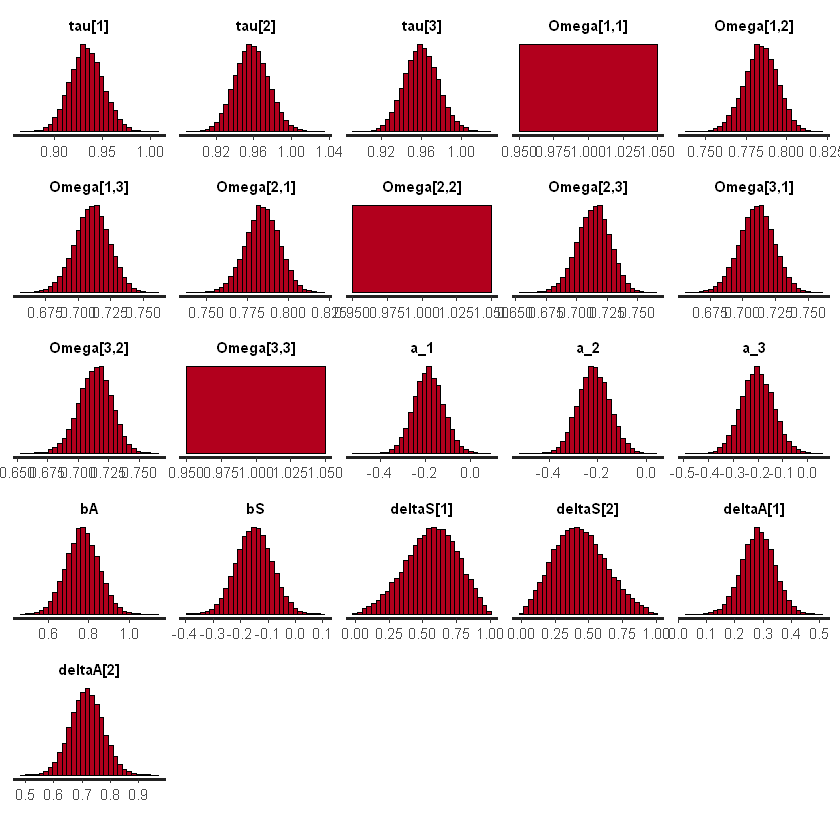

In [26]:
stan_hist(model_2, pars = pars)

### Investigating the problematic $k$ values
In the $elpd_{loo}$ calculation above there were some problematic high $k$ values, and some extremely low effective sample sizes. The analysis below reveals that the parameters for which the effective sample size is very low ($<100$) are a subset of those for which the $k$ value is high ($>0.5$), and both occur for data points where exam results are imputed. The presence of these high $k$ values makes the $elpd_{loo}$ estimate unreliable, but it should not indicate a problem with the estimates of the parameters not corresponding to imputed data (e.g $\beta_S$, which is what we're interested in). 

In [27]:
low_n_effs <- which(psis_n_eff_values(loo_2)< 100)

indices_1 <- which(is.na(df_m$Score_1_std))
indices_2 <- which(is.na(df_m$Score_2_std))
indices_3 <- which(is.na(df_m$Score_3_std))

NAs = union(union(indices_1, indices_2),indices_3)

In [28]:
length(NAs)

[1] 385

In [29]:
length(low_n_effs)

[1] 349

In [30]:
length(intersect(NAs, low_n_effs))

[1] 349

In [31]:
high_k <- which(pareto_k_values(loo_2)> 0.5)
length(high_k)

[1] 385

In [32]:
length(intersect(high_k, NAs))

[1] 385

In [33]:
length(intersect(high_k, low_n_effs))

[1] 349

### 5. Conclusions<a id='conc'></a>
Combining the data into a single more sophisticated model provides stronger evidence for an effect of section numbering than the were obtained in the 1st notebook (dealing with Y2 data), and toned down the claims of the best model from the 2nd notebook (dealing with Y1 data). Our first model here (without imputation) is fairly confident of a small effect of section numbering, without breaching the mystical 5% significance level. The second model (with imputation) is more confident, with over 98% of the probability mass of the $\beta_S$ estimate being below -0.01. 

It's worth noting that the effect sizes here are all quite small, with mean $\beta_S$ estimate from the imputation model being around -0.15. This is 'plausibly small', and fits in with the classical power analyses from the 1st and 2nd notebooks which provided evidence against effect sizes larger than around $d= 0.2$ to $0.3$.

For reference, the calculation from the first notebook indicates a standard deviation for exam scores of around 20 points. So. on the outcome scale, using the mean estimates the $\beta_S=0.15$ and $\delta^S=(0.56,0.44)$, a student in section 1 will, as a rough average, score an additional 1.7 points on an exam over a section 2 student, and 3 marks over a section 3 student, purely by virtue of having been placed in section 1. For a more detailed analysis, below is a plot on the outcome scale using the simulated draws from the posteriors of $\beta_S$ and $\delta^S$, along with a standard deviation for exam results calculated by pooling all the available exam data (on the assumption that the populations have the same standard deviation).   



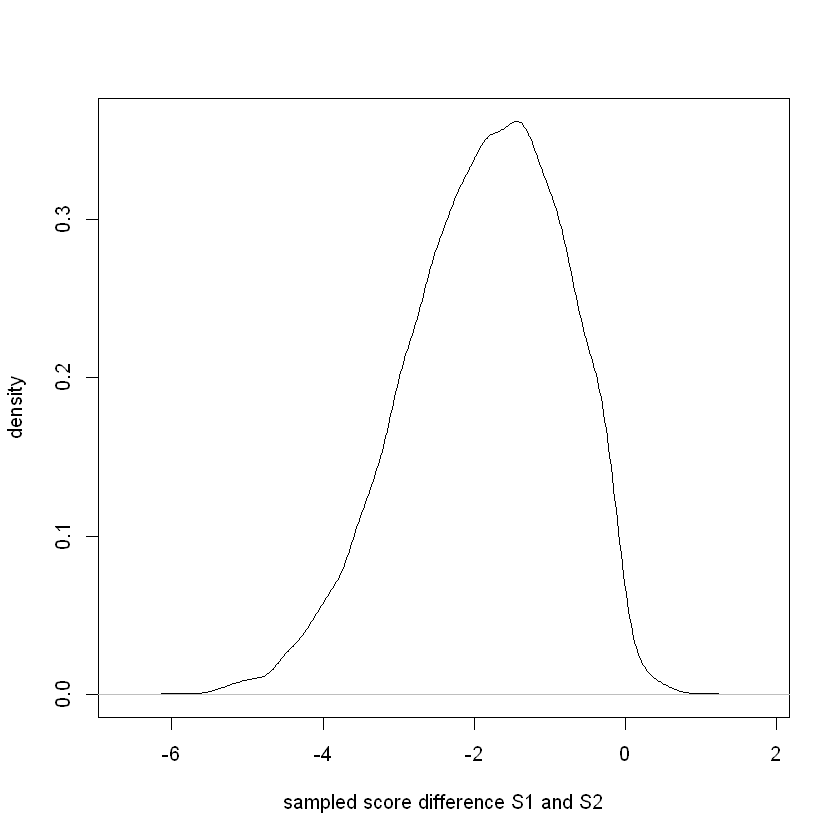

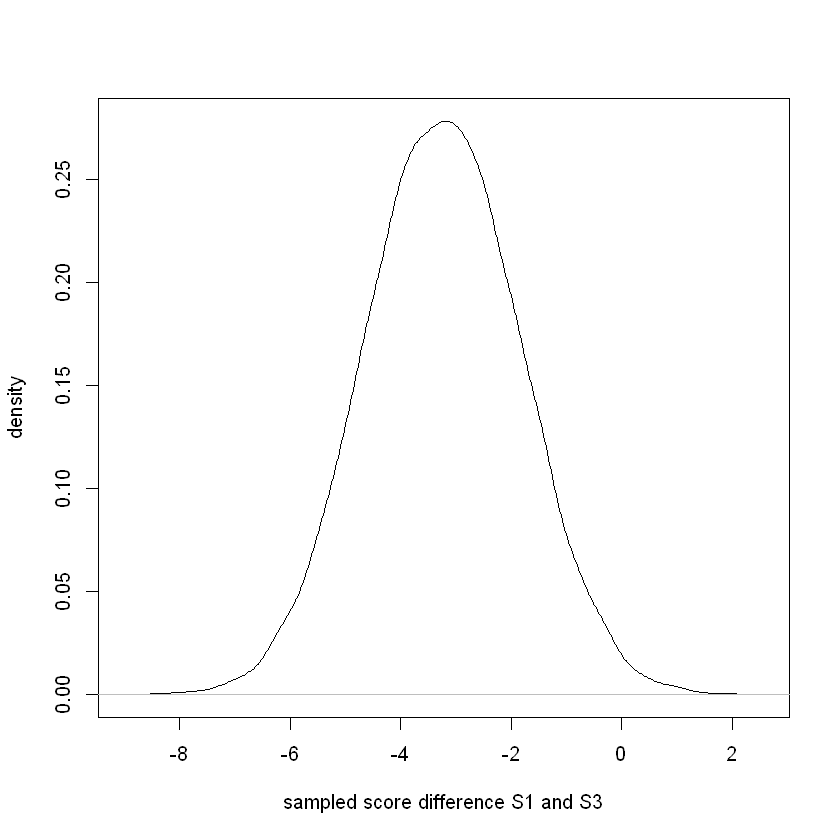

In [34]:
draws <- extract(model_2, pars = c('bS', 'deltaS'), permuted = TRUE, inc_warmup = FALSE,
  include = TRUE)

s <- sd(c(df_base$Score_1, df_base$Score_2, df_base$Score_3), na.rm = TRUE)

diff_S2 <- density(draws$bS * draws$deltaS[,1] * s) 

diff_S3 <- density(draws$bS * s) 

plot(diff_S2, ylab = "density", xlab = 'sampled score difference S1 and S2', main ='')

plot(diff_S3, ylab = "density", xlab = 'sampled score difference S1 and S3', main ='')

This expands on the rough calculation from the previous paragraph. Our model is quite confident of a small effect of section numbering on student outcome, after accounting for academic selection. Is this enough to warrant a change in policy? Well, as discussed in the conclusions to the first notebook, we cannot answer this question without taking into account the cost of being wrong. It seems to me that students randomly assigned to section 1 probably getting, on average, roughly 3 extra marks on exams compared to students similarly assigned to section 3 is potentially a problem. We have not thoroughly investigated the causes of this difference, so it remains possible that it is 'fair' according to some mechanism we have not considered, and also of course the model allows there to be no difference, or even a difference flipped the other way, though it assigns a relatively low probability to this. 

The idea of 'fairness' here also deserves some attention. If the effect described by our model here is indeed real, then quite possibly it arises from some kind of psychological conditioning of the students. By which I mean, students in section 1 may end up working slightly harder, on average, than their peers in section 3, and that this difference in attitude and effort accounts for the difference in outcomes. If this were the case, describing the advantage as 'unfair' may seem a little strange, given that ultimately the difference arises from the students' own efforts and capabilities on the occasions of the exams. However, I would argue that setting one group of students up with a (small) psychological advantage over another by an essentially random mechanism is unfair. As an extreme example to illustrate the point, imagine assigning students randomly into two groups, and encouraging one group of students in their studies while telling the other group that their efforts are useless and that they can never be successful. Come exam day the first group would quite likely be better prepared for the exam and do better on it, but at the same time most people would likely agree that the situation was unfair on the second group. If in our case the students in lower numbered sections do derive some small but noticeable psychological advantage over students in higher numbered sections, then this seems to me to be wrong for a similar reason, though obviously to a lesser degree. We should work to ensure a level playing field for our students. This is not always possible, and there are many relevant variables that we are not able to control that may disadvantage some students over others. But since we can quite easily control this, it seems at least reasonable to think about doing so.       

So, assuming the advantage of students with lower section numbers here is real and not 'fair' by some unknown mechanism, the cost of being wrong by doing nothing is that unfairness remains embedded in the system, systematically slightly disadvantaging students from higher numbered sections for years to come.       

On the other hand, if the effect is much smaller than the model suspects, the cost of being wrong by making a change is the administrative work in changing the existing nomenclature. There is also the possibility of introducing some naming scheme that introduces a problem (either the same as discussed here or a new, unforeseen issue).  

I am not an administrator, so I can't fully count the costs of changing existing naming systems, but at the very least I would be wary of using similar systems in the future. As always, more data could likely add clarity. Further study, etc. etc.